In [1]:
# !pip install lime
# !pip install shap

In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.datasets import load_breast_cancer
import warnings
random_state=42


# DATA

In [3]:
def load_breast_data():
    breast = load_breast_cancer()
    feature_names = list(breast.feature_names)
    X, y = pd.DataFrame(breast.data, columns=feature_names), breast.target
    dataset = {
        'problem': 'classification',
        'full': {
            'X': X,
            'y': y,
            'class_names': breast.target_names
        },
    }
    return dataset, feature_names

In [4]:
dataset, feature_names = load_breast_data()
X, y, class_names = dataset['full']['X'], dataset['full']['y'], dataset['full']['class_names'] 
class_name = 'label'

In [5]:
id2label = {i: class_names[i] for i in range(len(class_names))}

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=random_state)

In [7]:
train_df = X_train.copy(deep=True)
train_df [class_name] = y_train
test_df = X_test.copy(deep=True)
test_df [class_name] = y_test

In [8]:
train_df.head(n=5)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
337        18.77         21.43          122.90     1092.0          0.09116   
91         15.37         22.76          100.20      728.2          0.09200   
270        14.29         16.82           90.30      632.6          0.06429   
20         13.08         15.71           85.63      520.0          0.10750   
40         13.44         21.58           86.18      563.0          0.08162   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
337           0.14020         0.10600              0.06090         0.1953   
91            0.10360         0.11220              0.07483         0.1717   
270           0.02675         0.00725              0.00625         0.1508   
20            0.12700         0.04568              0.03110         0.1967   
40            0.06031         0.03110              0.02031         0.1784   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
337                 0.06083  ...          34.37           161.10      1873.0   
91                  0.06097  ...          25.84           107.50       830.9   
270                 0.05376  ...          20.65            94.44       684.6   
20                  0.06811  ...          20.49            96.09       630.5   
40                  0.05587  ...          30.25           102.50       787.9   

     worst smoothness  worst compactness  worst concavity  \
337           0.14980            0.48270          0.46340   
91            0.12570            0.19970          0.28460   
270           0.08567            0.05036          0.03866   
20            0.13120            0.27760          0.18900   
40            0.10940            0.20430          0.20850   

     worst concave points  worst symmetry  worst fractal dimension  label  
337               0.20480          0.3679                  0.09870      0  
91                0.14760          0.2556                  0.06828      0  
270               0.03333          0.2458                  0.06120      1  
20                0.07283          0.3184                  0.08183      1  
40                0.11120          0.2994                  0.07146      0  

[5 rows x 31 columns]

# RF

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
rf.fit(X_train.values, y_train)

pred = rf.predict(X_test.values)

sklearn.metrics.f1_score(y_test, pred, average='binary')

0.9652777777777778

# XAI

In [10]:
# clf_predict_proba = rf.predict_proba
# clf_predict = rf.predict
id_to_explain = 7


In [11]:
class DummyModel:
    def __getattr__(self, name):
        self.__dict__[name] = DummyModel()
        return self.__dict__[name]

my_model = DummyModel()
my_model.predict_proba = rf.predict_proba
my_model.predict = rf.predict
my_model.classes_ = class_names #rf.classes_
my_model.predict_proba([X_test.iloc[id_to_explain]])

array([[0.85, 0.15]])

## LIME

In [12]:
# https://vishesh-gupta.medium.com/understanding-your-model-with-lime-d7704d984696

In [13]:
import lime
import lime.lime_tabular

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values[:,:], feature_names = feature_names, class_names=class_names,
                                                   categorical_features=None,
                                                   categorical_names=None,discretizer='decile',kernel_width=5,discretize_continuous=True,verbose=True)

In [15]:
exp = explainer.explain_instance(X_test.iloc[id_to_explain,:], my_model.predict_proba, num_features=4)

Intercept 0.6205119509907568
Prediction_local [0.35081061]
Right: 0.15


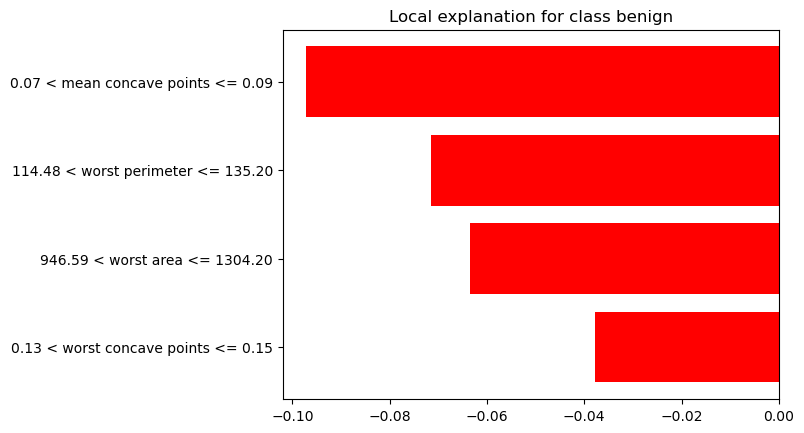

In [16]:
%matplotlib inline
fig = exp.as_pyplot_figure(label=1)

In [17]:
exp.show_in_notebook(show_all=False)

In [18]:
pd.DataFrame(exp.as_list(),columns=['Feature','Contribution'])

Feature  Contribution
0   0.07 < mean concave points <= 0.09     -0.097094
1   114.48 < worst perimeter <= 135.20     -0.071421
2       946.59 < worst area <= 1304.20     -0.063395
3  0.13 < worst concave points <= 0.15     -0.037792

In [19]:
# Using discretize_continuous =False

In [20]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values[:,:],feature_names = feature_names,class_names=class_names,
                                                   categorical_features=None, 
                                                   categorical_names=None,kernel_width=5,discretize_continuous=False,verbose=True)

#getting the lime prediction for an observation
exp = explainer.explain_instance(X_test.iloc[id_to_explain,:],rf.predict_proba, num_features=4)

Intercept 0.49909394659245
Prediction_local [0.39452261]
Right: 0.15


In [21]:
exp.show_in_notebook(show_all=False)

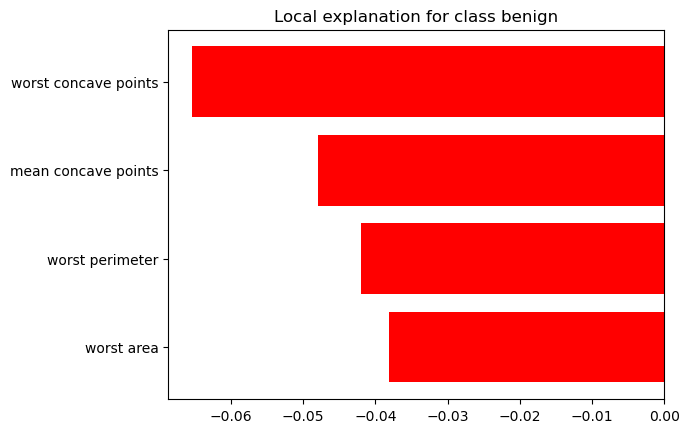

In [22]:
#variable level contribution
%matplotlib inline
fig = exp.as_pyplot_figure(label=1)

In [23]:
pd.DataFrame(exp.as_list(),columns=['Feature','Contribution'])

Feature  Contribution
0  worst concave points     -0.065413
1   mean concave points     -0.047990
2       worst perimeter     -0.042064
3            worst area     -0.038194

In [24]:
X_test.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

## SHAP

In [25]:
# https://safjan.com/kernelshap-treeshap-two-most-popular-variations-of-the-shap-method/
# https://www.kdnuggets.com/2023/08/shap-values-model-interpretability-machine-learning.html

In [26]:
import shap
shap.plots.initjs()

In [27]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

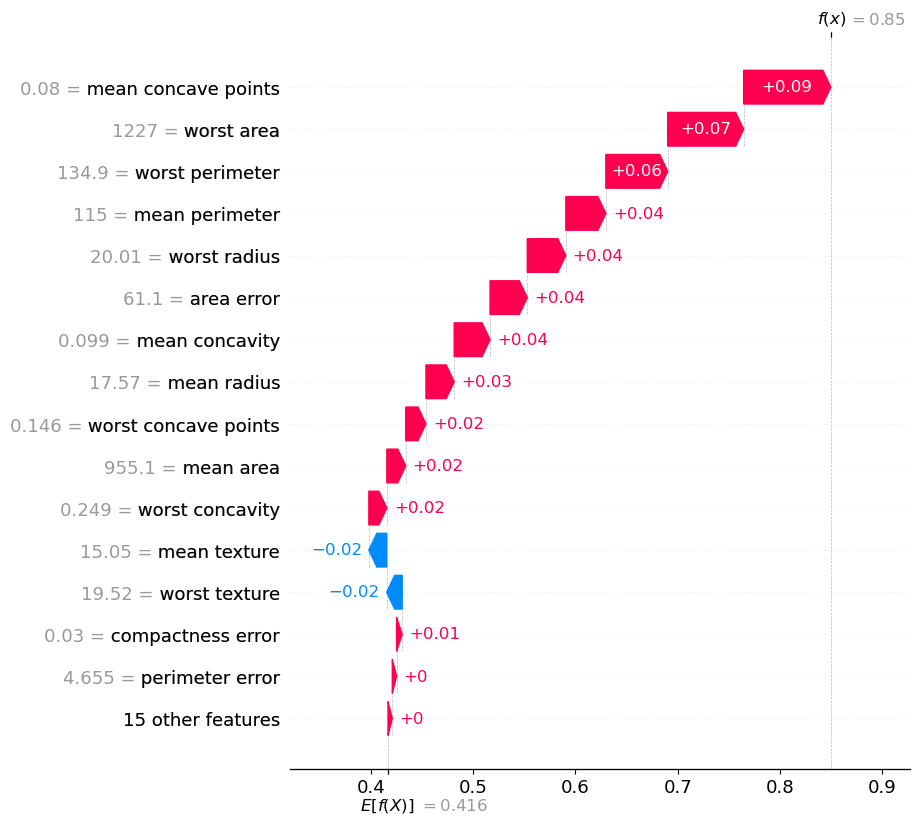

In [28]:
# https://github.com/shap/shap/issues/3172
exp = explainer(X_test)
output_to_explain = 0
shap.plots.waterfall(exp[id_to_explain,:,output_to_explain], max_display=16)
# shap.plots.waterfall(exp[id_to_explain,:,1], max_display=6)

In [29]:
shap_values[1].shape, X_test.shape

((30, 2), (456, 30))

In [30]:
shap_values[:,:,0].shape, X_test.shape

((456, 30), (456, 30))

In [31]:
shap.plots.force(explainer.expected_value[0], shap_values[id_to_explain,:,0], X_test.iloc[id_to_explain, :])

In [32]:
# https://www.youtube.com/watch?v=L8_sVRhBDLU&ab_channel=ADataOdyssey
shap.plots.force(explainer.expected_value[0], shap_values[id_to_explain:id_to_explain+10,:,0], feature_names=feature_names)
# shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.columns)

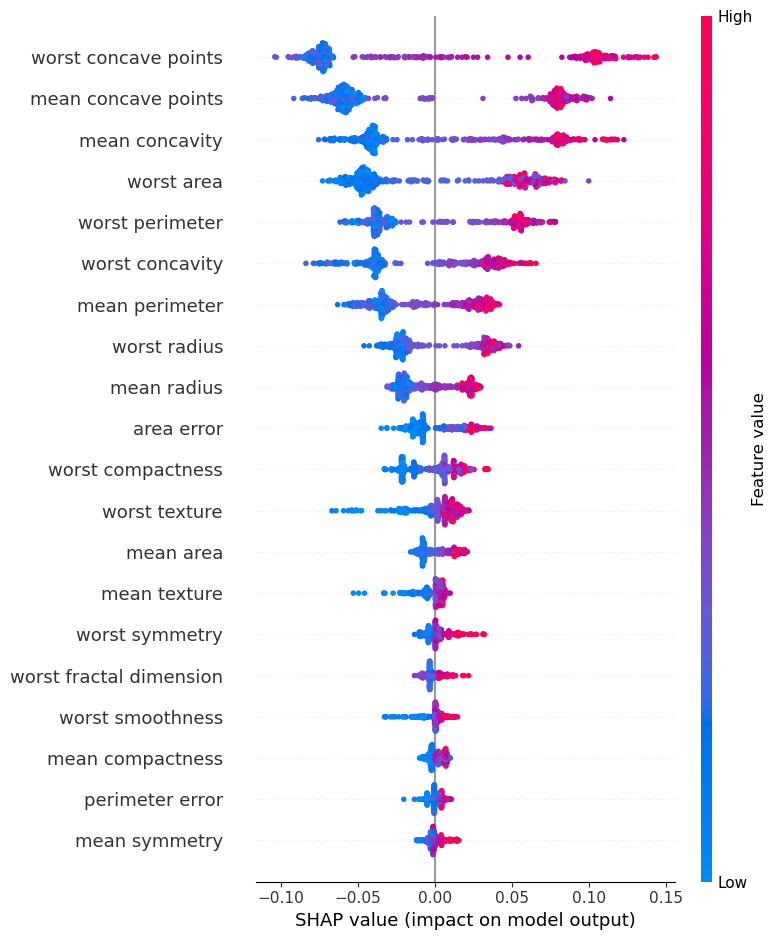

In [33]:
shap.summary_plot(shap_values[:,:,0], X_test)

## Anchors

In [34]:
# https://heka-ai.medium.com/use-anchor-to-better-understand-your-machine-learning-model-dd581f6d0f6f
# https://github.com/marcotcr/anchor/blob/master/notebooks/Anchor%20on%20tabular%20data.ipynb

In [35]:
# !pip install anchor-exp

In [36]:
from anchor import utils
from anchor import anchor_tabular
import re

In [37]:
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.values[:,:],
    {})

In [38]:
print('Prediction: ', explainer.class_names[my_model.predict([X_test.iloc[id_to_explain, :].values])[0]])

Prediction:  malignant


In [39]:
np.random.seed(random_state)
exp = explainer.explain_instance(X_test.iloc[id_to_explain, :].values, my_model.predict, threshold=0.97)

In [40]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: concave points error <= 0.02 AND worst perimeter > 127.00 AND mean fractal dimension > 0.06
Precision: 1.00
Coverage: 0.03


In [41]:
exp.features()

[17, 22, 9]

In [42]:
def get_df_query_from_rules(exp_anchors):
    q = ''
    for anchor_name in exp_anchors:
        idx = re.search('<|>|=', anchor_name).start()
        if len(q):
            q += ' & '
        q += '`' + anchor_name[:idx-1] + '` ' + anchor_name[idx:]
    return q
anchor_query = get_df_query_from_rules(exp.names())
anchor_query

'`concave points error` <= 0.02 & `worst perimeter` > 127.00 & `mean fractal dimension` > 0.06'

In [43]:
X_test
X_test.query(anchor_query).shape

(48, 30)

In [44]:
print(exp.names())
fit_anchor = X_test.query(anchor_query)
np.mean(my_model.predict(fit_anchor.values) == my_model.predict([X_test.iloc[id_to_explain, :]]))

['concave points error <= 0.02', 'worst perimeter > 127.00', 'mean fractal dimension > 0.06']


1.0

In [45]:
# Get test examples where the anchor applies
print('Anchor test precision: %.2f' % (np.mean(my_model.predict(fit_anchor.values) == my_model.predict([X_test.iloc[id_to_explain, :]]))))
print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(X_test.shape[0])))

Anchor test precision: 1.00
Anchor test coverage: 0.11


## LORE

In [46]:
# https://www.ai4europe.eu/research/ai-catalog/lore
# https://github.com/rinziv/LORE_ext/blob/master/examples/lore_example.py
# https://doi.org/10.1109/ACCESS.2021.3116481 #Explainable Artificial Intelligence for Tabular Data: A Survey <-- can generate counterfactuals

In [47]:
# !pip install LORE-ext

In [48]:
from lore_explainer.util import neuclidean
from lore_explainer.lorem import LOREM

In [49]:
numeric_columns = list(X_test._get_numeric_data().columns)
numeric_columns

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [50]:
from collections import defaultdict

def get_real_feature_names(rdf, numeric_columns, class_name):
    if isinstance(class_name, list):
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c not in class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c not in class_name]
    else:
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names
real_feature_names = get_real_feature_names(X_test, numeric_columns, class_name)
real_feature_names

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
        else:
            j += 1
    return features_map

features_map = get_features_map(feature_names, real_feature_names) #seems to exclude class label column, which is already cleaned
features_map

defaultdict(dict,
            {0: {'mean radius': 0},
             1: {'mean texture': 1},
             2: {'mean perimeter': 2},
             3: {'mean area': 3},
             4: {'mean smoothness': 4},
             5: {'mean compactness': 5},
             6: {'mean concavity': 6},
             7: {'mean concave points': 7},
             8: {'mean symmetry': 8},
             9: {'mean fractal dimension': 9},
             10: {'radius error': 10},
             11: {'texture error': 11},
             12: {'perimeter error': 12},
             13: {'area error': 13},
             14: {'smoothness error': 14},
             15: {'compactness error': 15},
             16: {'concavity error': 16},
             17: {'concave points error': 17},
             18: {'symmetry error': 18},
             19: {'fractal dimension error': 19},
             20: {'worst radius': 20},
             21: {'worst texture': 21},
             22: {'worst perimeter': 22},
             23: {'worst area': 23},
    

In [51]:
lore_explainer = LOREM(X_test.values, my_model.predict, feature_names, class_name, id2label, numeric_columns, features_map,
                       neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False,
                       size=1000, ocr=0.1, random_state=random_state, ngen=10, bb_predict_proba=my_model.predict_proba,
                       verbose=True)
# May need fixing in lore_explainer/util.py , at line 55: values = values.astype(np.float64) <- due to numpy update

calculating feature values


In [52]:
exp = lore_explainer.explain_instance(X_test.iloc[id_to_explain].values, samples=1000, use_weights=True, metric=neuclidean)

print(exp)

generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	500   	0.496654	0.496654	0.496654
1  	433   	0.731693	0.496654	0.993307
2  	425   	0.936757	0.496654	0.993307
3  	433   	0.977141	0.484992	0.993307
4  	430   	0.978585	0.603639	0.993307
5  	435   	0.98295 	0.540775	0.993307
6  	434   	0.981418	0.579716	0.993307
7  	416   	0.980241	0.64985 	0.993307
8  	433   	0.979729	0.536772	0.993307
9  	423   	0.982877	0.715093	0.993307
10 	408   	0.982435	0.55595 	0.993307
gen	nevals	avg	min	max
0  	500   	0.5	0.5	0.5
1  	417   	0.50494	0.349897	0.736217
2  	420   	0.524608	0.354222	0.81972 
3  	425   	0.573042	0.402089	0.93109 
4  	438   	0.629512	0.170153	0.960098
5  	433   	0.672838	0.131908	0.960098
6  	431   	0.716241	0.404947	0.96641 
7  	429   	0.755522	0.33124 	0.966413
8  	415   	0.795666	0.367948	0.96641 
9  	418   	0.802829	0.394294	0.968004
10 	442   	0.801281	0.366125	0.968247
synthetic neighborhood class counts {'malignant': 527, 'benign': 673}
learning local

In [53]:
rule_query = get_df_query_from_rules(exp.rule._pstr()[1:-1].strip().split(', '))
rule_query

'`worst concave points` > 0.11 & `worst area` > 623.21 & `mean concave points` > 0.02 & `worst concavity` > 0.03 & `worst smoothness` > 0.09 & `fractal dimension error` > -0.00'

In [54]:
fit_rule = X_test.query(rule_query)
np.mean(my_model.predict(fit_rule.values) == my_model.predict([X_test.iloc[id_to_explain, :]]))

0.8938547486033519

In [55]:
# Get test examples where the anchor applies
print('Rule test precision: %.2f' % (np.mean(my_model.predict(fit_rule.values) == my_model.predict([X_test.iloc[id_to_explain, :]]))))
print('Rule test coverage: %.2f' % (fit_rule.shape[0] / float(X_test.shape[0])))

Rule test precision: 0.89
Rule test coverage: 0.39


## DiCE 

In [56]:
# https://github.com/interpretml/DiCE
# https://github.com/interpretml/DiCE/blob/main/docs/source/notebooks/Benchmarking_different_CF_explanation_methods.ipynb

In [57]:
# !pip install dice-ml

In [58]:
from dice_ml import Dice
import dice_ml
from dice_ml.utils import helpers
import timeit

In [59]:
train_df.drop(columns=[class_name]).columns.values.tolist()

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [60]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 337 to 458
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              90 non-null     float64
 1   mean texture             90 non-null     float64
 2   mean perimeter           90 non-null     float64
 3   mean area                90 non-null     float64
 4   mean smoothness          90 non-null     float64
 5   mean compactness         90 non-null     float64
 6   mean concavity           90 non-null     float64
 7   mean concave points      90 non-null     float64
 8   mean symmetry            90 non-null     float64
 9   mean fractal dimension   90 non-null     float64
 10  radius error             90 non-null     float64
 11  texture error            90 non-null     float64
 12  perimeter error          90 non-null     float64
 13  area error               90 non-null     float64
 14  smoothness error         

In [61]:
d = dice_ml.Data(dataframe=test_df,
                 continuous_features=train_df.drop(columns=[class_name]).columns.values.tolist(),
                 outcome_name=class_name)

In [62]:
m = dice_ml.Model(model=my_model, backend="sklearn")

In [63]:
exp_random = Dice(d, m, method="random")
exp_genetic = Dice(d, m, method="genetic")
exp_KD = Dice(d, m, method="kdtree")

In [64]:

query_instances = X_test.iloc[id_to_explain:id_to_explain+1,:]
query_instances.index

Int64Index([29], dtype='int64')

In [65]:
num_loops = 2
k = 2

elapsed_random = 0
elapsed_kd = 0
elapsed_genetic = 0

for _ in range(num_loops):
    for q in query_instances:
        if q in d.categorical_feature_names:
            query_instances.loc[:, q] = \
                [np.unique(random.choice(test_df[q].values)) for _ in query_instances.index]
        else:
            query_instances.loc[:, q] = \
                [np.random.uniform(test_df[q].min(), test_df[q].max()) for _ in query_instances.index]

    start_time = timeit.default_timer()
    dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=k,
                                                          desired_class=0, verbose=False)
    elapsed_random += timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    dice_exp = exp_genetic.generate_counterfactuals(query_instances, total_CFs=k, desired_class=0,
                                                    yloss_type="hinge_loss", verbose=False)
    elapsed_genetic += timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    dice_kd = exp_KD.generate_counterfactuals(query_instances, total_CFs=k, desired_class=0,
                                              verbose=False)
    elapsed_kd += timeit.default_timer() - start_time

m_random, s_random = divmod(elapsed_random, 60)
print('For Independent random sampling of features: Total time taken to generate %d' % num_loops,
      'sets of %d' % k, 'counterfactuals each: %02d' % m_random, 'min %02d' % s_random, 'sec')

m_kd, s_kd = divmod(elapsed_kd, 60)
print('For querying from a KD tree: Total time taken to generate %d' % num_loops,
      'sets of %d' % k, 'counterfactuals each: %02d' % m_kd, 'min %02d' % s_kd, 'sec')

m_genetic, s_genetic = divmod(elapsed_genetic, 60)
print('For genetic algorithm: Total time taken to generate %d' % num_loops,
      'sets of %d' % k, 'counterfactuals each: %02d' % m_genetic, 'min %02d' % s_genetic, 'sec')

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]

For Independent random sampling of features: Total time taken to generate 2 sets of 2 counterfactuals each: 00 min 00 sec
For querying from a KD tree: Total time taken to generate 2 sets of 2 counterfactuals each: 00 min 14 sec
For genetic algorithm: Total time taken to generate 2 sets of 2 counterfactuals each: 00 min 00 sec


In [66]:
print('random'); dice_exp_random.visualize_as_dataframe()
print('genetic'); dice_exp.visualize_as_dataframe()
print('kd tree knn'); dice_kd.visualize_as_dataframe()

random
Query instance (original outcome : malignant)


mean radius  mean texture  mean perimeter    mean area  mean smoothness  \
0    20.632452     29.163713      147.042084  1775.216431         0.133794   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1392        0.280709             0.107418       0.201381   

   mean fractal dimension  ...  worst texture  worst perimeter   worst area  \
0                0.054103  ...      21.854691       108.097305  1012.999207   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0          0.208592           0.623566          1.15815              0.236179   

   worst symmetry  worst fractal dimension      label  
0        0.231715                 0.112385  malignant  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: malignant)


mean radius  mean texture  mean perimeter    mean area  mean smoothness  \
0    20.632452     29.163713      147.042077  1775.216404         0.133794   
1    20.632452     29.163713      147.042077  1775.216404         0.133794   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1392        0.300000             0.107418       0.201381   
1            0.1392        0.280709             0.107418       0.201381   

   mean fractal dimension  ...  worst texture  worst perimeter   worst area  \
0                0.054103  ...      21.854691       108.097309  1012.999178   
1                0.054103  ...      21.854691       108.097309  1012.999178   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0          0.208592           0.623566          1.15815              0.236179   
1          0.202700           0.623566          1.15815              0.236179   

   worst symmetry  worst fractal dimension      label  
0        0.231715                 0.112385  malignant  
1        0.231715                 0.112385  malignant  

[2 rows x 31 columns]

genetic
Query instance (original outcome : malignant)


mean radius  mean texture  mean perimeter    mean area  mean smoothness  \
0    20.632452     29.163713      147.042084  1775.216431         0.133794   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1392        0.280709             0.107418       0.201381   

   mean fractal dimension  ...  worst texture  worst perimeter   worst area  \
0                0.054103  ...      21.854691       108.097305  1012.999207   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0          0.208592           0.623566          1.15815              0.236179   

   worst symmetry  worst fractal dimension      label  
0        0.231715                 0.112385  malignant  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: malignant)


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        19.10         26.29           129.1     1132.0           0.1215   
0        20.18         19.54           133.8     1250.0           0.1133   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1791             0.2                  0.1         0.1634   
0            0.1489             0.2                  0.1         0.1724   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07224  ...           32.7            141.3      1298.0   
0                 0.06053  ...           25.1            146.0      1479.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1392             0.2817              0.2                   0.2   
0            0.1665             0.2942              0.5                   0.2   

   worst symmetry  worst fractal dimension      label  
0          0.2311                  0.09203  malignant  
0          0.3032                  0.08075  malignant  

[2 rows x 31 columns]

kd tree knn
Query instance (original outcome : malignant)


mean radius  mean texture  mean perimeter    mean area  mean smoothness  \
0    20.632452     29.163713      147.042084  1775.216431         0.133794   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1392        0.280709             0.107418       0.201381   

   mean fractal dimension  ...  worst texture  worst perimeter   worst area  \
0                0.054103  ...      21.854691       108.097305  1012.999207   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0          0.208592           0.623566          1.15815              0.236179   

   worst symmetry  worst fractal dimension      label  
0        0.231715                 0.112385  malignant  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: malignant)


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
83         19.10         26.29           129.1     1132.0           0.1215   
432        20.18         19.54           133.8     1250.0           0.1133   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
83             0.1791             0.2                  0.1         0.1634   
432            0.1489             0.2                  0.1         0.1724   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
83                  0.07224  ...           32.7            141.3      1298.0   
432                 0.06053  ...           25.1            146.0      1479.0   

     worst smoothness  worst compactness  worst concavity  \
83             0.1392             0.2817              0.2   
432            0.1665             0.2942              0.5   

     worst concave points  worst symmetry  worst fractal dimension      label  
83                    0.2          0.2311                  0.09203  malignant  
432                   0.2          0.3032                  0.08075  malignant  

[2 rows x 31 columns]

In [67]:
print('genetic> opp');exp_genetic.generate_counterfactuals(query_instances, total_CFs=4, desired_class="opposite").visualize_as_dataframe()

genetic> opp


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]

Query instance (original outcome : malignant)


mean radius  mean texture  mean perimeter    mean area  mean smoothness  \
0    20.632452     29.163713      147.042084  1775.216431         0.133794   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1392        0.280709             0.107418       0.201381   

   mean fractal dimension  ...  worst texture  worst perimeter   worst area  \
0                0.054103  ...      21.854691       108.097305  1012.999207   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0          0.208592           0.623566          1.15815              0.236179   

   worst symmetry  worst fractal dimension      label  
0        0.231715                 0.112385  malignant  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: benign)


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        14.95         18.77            97.8      689.5           0.0814   
0        14.53         13.98            93.9      644.2           0.1099   
0        14.34         13.47            92.5      641.2           0.0991   
0        14.04         15.98            89.8      611.2           0.0846   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1167             0.1                  0.0         0.1744   
0            0.0924             0.1                  0.1         0.1650   
0            0.0762             0.1                  0.0         0.2075   
0            0.0589             0.0                  0.0         0.1714   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.06493  ...           25.5            107.1       809.7   
0                 0.06121  ...           16.9            103.1       749.9   
0                 0.05448  ...           16.9            110.4       873.2   
0                 0.05898  ...           21.6            101.2       750.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.0997             0.2521              0.2                   0.1   
0            0.1347             0.1478              0.1                   0.1   
0            0.1297             0.1525              0.2                   0.1   
0            0.1195             0.1252              0.1                   0.1   

   worst symmetry  worst fractal dimension   label  
0          0.2852                  0.09218  benign  
0          0.2606                  0.07810  benign  
0          0.3062                  0.06072  benign  
0          0.2725                  0.07234  benign  

[4 rows x 31 columns]